### Library 

In [5]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

path_main_folder = '/home/restor/partage/apogee-parades/AED_autoencoder'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE_temp, CVAE
from conso.load_shape_data import *  
from Visualisation.buildProjector import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

## Recette pour apprendre un bon autoencoder conditionnel
Apres avoir augmenté le nombre de couches, inséré des sigmoids proches de l'espace latent de l'autoencoder, donner plus de poids à la loss de reconstruction (cf référence d'Antoine Rosin sur l'over pruning), et augmenter l'apprentissage, on atteint une loss de reconstruction de l'ordre de 0.4 qui donne de bons résultats et de belles projections!
On peut augmenter l'importance de la KL loss mais le temps d'apprentissage doit être augmenté (1000 pour beta=0.01 vs 500 pour beta=0.01.
Question: souhaite-t-on un espace très gaussien dans toutes les directions ? Ce serait intéressant si l'on souhaite générer des courbes de conso. Mais si l'on souhaite explorer l'espace latent, cela peut-être une contrainte potentiellement trop forte

A vérifier mais plus on passe de conditions, plus la loss de reconstruction devrait diminuer.

In [6]:
#un code pour n'afficher que quelques resultats pendant l'entrainement de l'autoencoder

nbsample=20
from keras.callbacks import TensorBoard
from keras.callbacks import Callback

class NEpochLogger(Callback):
    def __init__(self, display):
        self.seen = 0
        self.display = display

    def on_epoch_end(self, epoch, logs={}):
        self.seen += logs.get('size', 0)
        if epoch % self.display == 0:
            metrics_log = ''
            for k in self.params['metrics']:
                if k in logs:
                    val = logs[k]
                    if abs(val) > 1e-3:
                        metrics_log += ' - %s: %.4f' % (k, val)
                    else:
                        metrics_log += ' - %s: %.4e' % (k, val)
            print('{} Epochs ... {}'.format(epoch, metrics_log))

### Load and shape data 

In [7]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [8]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [9]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [10]:
# Change ganularity ?
name_granu = '30m'#'1H'
data_conso_df = change_granularity(data_conso_df, granularity="30min") #1H"

In [11]:
data_conso_df.head(5)

,ds,conso_nat_t0,002Th+0,005Th+0,015Th+0,027Th+0,070Th+0,110Th+0,120Th+0,130Th+0,...,630Th+0,643Th+0,645Th+0,650Th+0,675Th+0,690Th+0,747Th+0,meteo_natTh+0,type_tempo,is_holiday_day
0,2012-12-28 00:00:00,59679.0,7.7,7.90,7.2,7.10,6.40,11.30,8.70,9.10,...,10.90,13.00,11.40,11.4,13.20,14.20,15.2,8.857143,NaN,0.0
1,2012-12-28 00:30:00,58103.0,7.6,7.80,7.2,7.55,6.80,11.40,9.05,9.05,...,10.90,11.45,10.95,11.1,12.95,13.90,14.7,8.764286,NaN,0.0
2,2012-12-28 01:00:00,55354.0,7.5,7.70,7.2,8.00,7.20,11.50,9.40,9.00,...,10.90,9.90,10.50,10.8,12.70,13.60,14.2,8.671429,NaN,0.0
3,2012-12-28 01:30:00,55196.0,7.5,7.55,7.0,7.90,7.25,11.45,9.65,9.00,...,10.95,9.80,9.10,10.5,12.60,13.25,13.6,8.585714,NaN,0.0
4,2012-12-28 02:00:00,54324.0,7.5,7.40,6.8,7.80,7.30,11.40,9.90,9.00,...,11.00,9.70,7.70,10.2,12.50,12.90,13.0,8.500000,NaN,0.0


In [12]:
#changer la conso nat d'une moyenne a une moyenne pondérée
stations_meteo_csv = os.path.join(path_data, "StationsMeteoRTE.csv")
stations_meteo_df = pd.read_csv(stations_meteo_csv, sep=";")
colsToKeepWeather=[s for s in data_conso_df.columns.get_values() if 'Th+0' in s]
colsToKeepWeather.remove('meteo_natTh+0')
data_conso_df['meteo_natTh+0_Old'] = data_conso_df['meteo_natTh+0'] 
data_conso_df['meteo_natTh+0'] = np.dot(data_conso_df[colsToKeepWeather],stations_meteo_df['Poids'])

In [13]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

In [14]:
x_conso.head(5)

,ds,conso_nat_t0,meteo_natTh+0,meteo_natTh+0_Old
0,2012-12-28 00:00:00,59679.0,8.817600,8.857143
1,2012-12-28 00:30:00,58103.0,8.690875,8.764286
2,2012-12-28 01:00:00,55354.0,8.564150,8.671429
3,2012-12-28 01:30:00,55196.0,8.440525,8.585714
4,2012-12-28 02:00:00,54324.0,8.316900,8.500000


# Creer le dataset de l'autoencodeur 1 - condition weekday

In [15]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [16]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [17]:
name_type_cond = 'm-wd-temp'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['weekday']#normalement is ne va pas chercher quel jour de la semaine, mais si c'est un jour weekend ou semaine ['weekday', 'temperature']

In [18]:

dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond, slidingWindowSize=0)

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:387: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:390: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:488: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [19]:
calendar_info = pd.DataFrame(dataset['train']['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

In [20]:
# modify dataset to fit with new data format
#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
cond_pre =dataset['train']['x'][1][:,:2]#[0] #dataset['train']['x'][1][:,:14] #les dimensions pour les conditions sans embeddings préalable
x = dataset['train']['x'][0]

dataset['train']['x'] = [x, cond_pre]#, to_emb]

### Build model

In [24]:
#on sauvegarde le dataset
path_out = os.path.join(path_main_folder, 'out')

In [25]:
# Parameters
e_dims=[48,35,24,12]#[24,12]#[48,40,30,20,14,8]
d_dims=[48,35,24,12]#[12,24]#[48,40,30,20,14,8]
emb_dims=0
cond_pre_dim = 1#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
to_emb_dim = 0#dataset['train']['x'][2].shape[1]
z_dim= 5
beta = 0.05 #0.1 pour une granularite 48

In [26]:
name_model = 'cvae_conso_WeekDay-30min-journalier'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [30]:
model = CVAE(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_dim=1,
                  z_dim=z_dim, 
                  beta=beta,
                  name=name_model, 
                  output=path_out)
                    #pDropout=0.5)

2
3
0
1
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 5), (None, 5 5409        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 5)            0           encoder[1][0]      

### Trainning model 

In [31]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
#os.path.join(path_out,name_model)

 #tensorboard = TensorBoard(log_dir=model_path,write_graph=True,write_images=True)



--- START TRAINING ---

0 Epochs ...  - loss: 15.5174 - kl_loss: 10.9564 - recon_loss: 14.9696
50 Epochs ...  - loss: 0.7261 - kl_loss: 5.6088 - recon_loss: 0.4457
100 Epochs ...  - loss: 0.6261 - kl_loss: 5.7714 - recon_loss: 0.3376
150 Epochs ...  - loss: 0.5515 - kl_loss: 5.8574 - recon_loss: 0.2586
200 Epochs ...  - loss: 0.5343 - kl_loss: 5.8393 - recon_loss: 0.2423
250 Epochs ...  - loss: 0.5202 - kl_loss: 5.8957 - recon_loss: 0.2254
300 Epochs ...  - loss: 0.5095 - kl_loss: 5.8983 - recon_loss: 0.2146
350 Epochs ...  - loss: 0.5103 - kl_loss: 5.9599 - recon_loss: 0.2123
400 Epochs ...  - loss: 0.4958 - kl_loss: 5.9189 - recon_loss: 0.1998
450 Epochs ...  - loss: 0.4961 - kl_loss: 5.9359 - recon_loss: 0.1993
500 Epochs ...  - loss: 0.4937 - kl_loss: 5.9589 - recon_loss: 0.1958
550 Epochs ...  - loss: 0.4888 - kl_loss: 5.9230 - recon_loss: 0.1927
600 Epochs ...  - loss: 0.4855 - kl_loss: 5.9443 - recon_loss: 0.1883
650 Epochs ...  - loss: 0.4937 - kl_loss: 6.0072 - recon_loss: 0

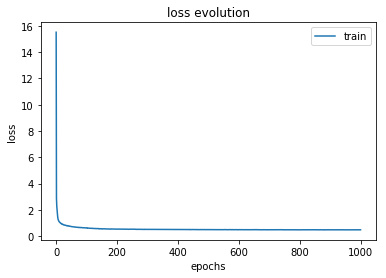

In [32]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
out_batch = NEpochLogger(display=50)
model.main_train(dataset, training_epochs=1000, batch_size=20, verbose=False,callbacks=[tensorboard,out_batch])

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

In [33]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    file.write(str(emb_dims) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

In [34]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [35]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [36]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [37]:
#temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond = dataset['train']['x'][1]
#cond = np.concatenate((cond_pre, temp_emb), axis=1)

x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

In [38]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])

In [39]:
log_dir=path_main_folder+"/notebooks/logs/projector_Conso_WeekDay_4couches"
os.makedirs(log_dir)

FileExistsError: [Errno 17] File exists: '/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_WeekDay_4couches'

In [40]:
import os,cv2
images=createLoadProfileImages(x,x_hat,nPoints)

<Figure size 432x288 with 0 Axes>

In [41]:

sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [42]:

x_reduced=x_encoded[0:nPoints,]
writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images,log_dir)

## Analyse prédiction de température
On essaie de prédire la température avec les plus proches voisins. Normalement on drevrait etre meilleur que dans l'autoencoder originel et ensuite on devrait etre moins bons une fois la tempréature prise en compte

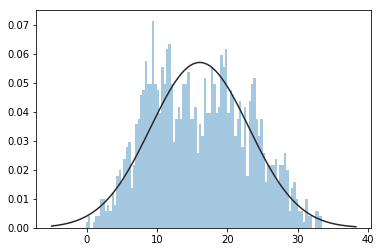

In [43]:
temperatureMax=[max(x_conso.loc[index*48:(index+1)*48-1,'meteo_natTh+0']) for index in range(0,nPoints)]
import seaborn as sn
sn.distplot(temperatureMax, kde=False, fit=stats.norm, bins=100)

In [44]:
from sklearn.neighbors import KNeighborsRegressor
k=5
knn = KNeighborsRegressor(n_neighbors=k)

yTemp=temperatureMax

knn.fit(x_reduced, yTemp)
train_accuracy= knn.score(x_reduced, yTemp)
train_accuracy

0.9031928825378968

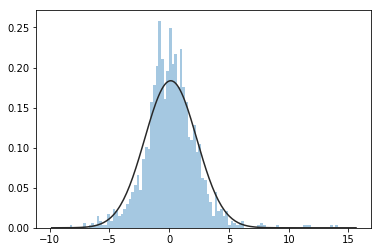

In [45]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)
#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

## classification si espace random


In [46]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsRegressor(n_neighbors=k)
knn_random.fit(x_reduced_random, yTemp)
train_accuracy_random= knn_random.score(x_reduced_random, yTemp)
train_accuracy_random

0.2262764020927717

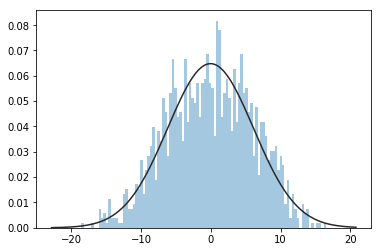

In [47]:
from sklearn.metrics import confusion_matrix
y_pred = knn_random.predict(x_reduced_random)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

# Creer le dataset de l'autoencodeur 1 - temperature


In [48]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [49]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [50]:
name_type_cond = 'm-wd-temp'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['temperature']#normalement is ne va pas chercher quel jour de la semaine, mais si c'est un jour weekend ou semaine ['weekday', 'temperature']

In [51]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond, slidingWindowSize=0)

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:387: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:390: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:482: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:488: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [52]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

In [53]:
# modify dataset to fit with new data format
#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
#cond_pre =dataset['train']['x'][1][:,:1]#[0] #dataset['train']['x'][1][:,:14] #les dimensions pour les conditions sans embeddings préalable
#to_emb=dataset['train']['x'][1][:,1:]
#cond_pre =dataset['train']['x'][1][:,:]
cond_pre=np.zeros((nPoints,1))
to_emb=dataset['train']['x'][1][:,:]
x = dataset['train']['x'][0]

dataset['train']['x'] = [x, cond_pre, to_emb]

### Build model

In [54]:
#on sauvegarde le dataset
path_out = os.path.join(path_main_folder, 'out')

In [63]:
# Parameters
e_dims=[48,35,24,12]#[24,12]#[48,40,30,20,14,8]
d_dims=[48,35,24,12]#[12,24]#[48,40,30,20,14,8]
to_emb_dim=dataset['train']['x'][2].shape[1]
cond_pre_dim = 1#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 5
beta = 0.01 #0.1 pour une granularite 48

In [64]:
name_model = 'cvae_conso_WeekDay_EmbTemp-30min-journalier'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [65]:
model = CVAE_temp(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=beta,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[8,4])

2
3
0
1
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
to_emb (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 4)            428         to_emb[0][0]                     
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
____________________________________________________________________________________

### Trainning model 

In [66]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
#os.path.join(path_out,name_model)

 #tensorboard = TensorBoard(log_dir=model_path,write_graph=True,write_images=True)



--- START TRAINING ---

0 Epochs ...  - loss: 12.9303 - kl_loss: 8.5736 - recon_loss: 12.8446
50 Epochs ...  - loss: 0.3116 - kl_loss: 12.3297 - recon_loss: 0.1883
100 Epochs ...  - loss: 0.2213 - kl_loss: 10.1110 - recon_loss: 0.1202
150 Epochs ...  - loss: 0.1851 - kl_loss: 8.8523 - recon_loss: 0.0966
200 Epochs ...  - loss: 0.1654 - kl_loss: 8.1101 - recon_loss: 0.0843
250 Epochs ...  - loss: 0.1565 - kl_loss: 7.7062 - recon_loss: 0.0795
300 Epochs ...  - loss: 0.1483 - kl_loss: 7.3738 - recon_loss: 0.0746
350 Epochs ...  - loss: 0.1424 - kl_loss: 7.2078 - recon_loss: 0.0703
400 Epochs ...  - loss: 0.1369 - kl_loss: 7.1169 - recon_loss: 0.0658
450 Epochs ...  - loss: 0.1361 - kl_loss: 6.9905 - recon_loss: 0.0662
500 Epochs ...  - loss: 0.1311 - kl_loss: 6.9229 - recon_loss: 0.0619
550 Epochs ...  - loss: 0.1305 - kl_loss: 6.8450 - recon_loss: 0.0621
600 Epochs ...  - loss: 0.1276 - kl_loss: 6.7295 - recon_loss: 0.0603
650 Epochs ...  - loss: 0.1260 - kl_loss: 6.7059 - recon_loss: 

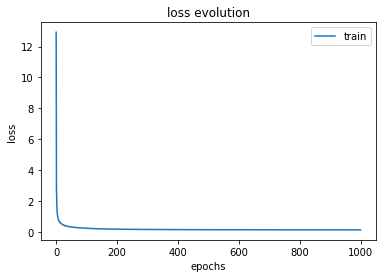

In [67]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
out_batch = NEpochLogger(display=50)
model.main_train(dataset, training_epochs=1000, batch_size=20, verbose=False,callbacks=[tensorboard,out_batch])

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

In [68]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    file.write(str(emb_dims) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

In [69]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [70]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [71]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [72]:
temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond_pre = dataset['train']['x'][1]
cond_emb = model.embedding.predict(dataset['train']['x'][2])
cond = np.concatenate((cond_pre, cond_emb), axis=1)

#cond  = dataset['train']['x'][1]
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

In [73]:
cond_emb.shape

(1830, 4)

In [74]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])

In [85]:
log_dir=path_main_folder+"/notebooks/logs/projector_Conso_WeekDay_Temp_4couches"
os.makedirs(log_dir)

FileExistsError: [Errno 17] File exists: '/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_WeekDay_Temp_4couches'

In [76]:
import os,cv2
images=createLoadProfileImages(x,x_hat,nPoints)

<Figure size 432x288 with 0 Axes>

In [86]:

sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [87]:

x_reduced=x_encoded[0:nPoints,]
writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images,log_dir)

## Analyse prédiction de température
On essaie de prédire la température avec les plus proches voisins. Normalement on drevrait etre meilleur que dans l'autoencoder originel et ensuite on devrait etre moins bons une fois la tempréature prise en compte

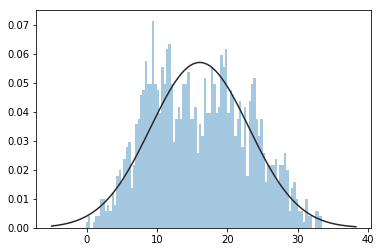

In [88]:
temperatureMax=[max(x_conso.loc[index*48:(index+1)*48-1,'meteo_natTh+0']) for index in range(0,nPoints)]
import seaborn as sn
sn.distplot(temperatureMax, kde=False, fit=stats.norm, bins=100)

In [89]:
from sklearn.neighbors import KNeighborsRegressor
k=5
knn = KNeighborsRegressor(n_neighbors=k)

yTemp=temperatureMax

knn.fit(x_reduced, yTemp)
train_accuracy= knn.score(x_reduced, yTemp)
train_accuracy

0.556548709974326

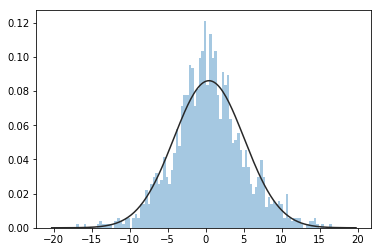

In [90]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)
#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

## classification si espace random


In [91]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsRegressor(n_neighbors=k)
knn_random.fit(x_reduced_random, yTemp)
train_accuracy_random= knn_random.score(x_reduced_random, yTemp)
train_accuracy_random

0.1825212579782084

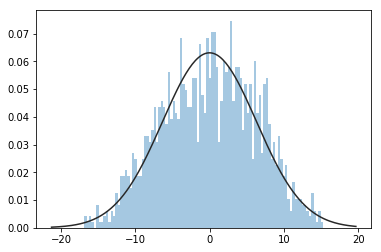

In [92]:
from sklearn.metrics import confusion_matrix
y_pred = knn_random.predict(x_reduced_random)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

# Creer le dataset de l'autoencodeur 1 - weekday + temperature


In [93]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [94]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [95]:
name_type_cond = 'm-wd-temp'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['weekday','temperature']#normalement is ne va pas chercher quel jour de la semaine, mais si c'est un jour weekend ou semaine ['weekday', 'temperature']

In [96]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond, slidingWindowSize=0)

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:387: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:390: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:482: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:488: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [97]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

In [98]:
# modify dataset to fit with new data format
#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
cond_pre =dataset['train']['x'][1][:,:1]#[0] #dataset['train']['x'][1][:,:14] #les dimensions pour les conditions sans embeddings préalable
#to_emb=dataset['train']['x'][1][:,1:]
#cond_pre =dataset['train']['x'][1][:,:]
#cond_pre=np.zeros((nPoints,1))
to_emb=dataset['train']['x'][1][:,1:]
x = dataset['train']['x'][0]

dataset['train']['x'] = [x, cond_pre, to_emb]

### Build model

In [99]:
#on sauvegarde le dataset
path_out = os.path.join(path_main_folder, 'out')

In [109]:
# Parameters
e_dims=[48,35,24,12]#[24,12]#[48,40,30,20,14,8]
d_dims=[48,35,24,12]#[12,24]#[48,40,30,20,14,8]
to_emb_dim=dataset['train']['x'][2].shape[1]
cond_pre_dim = 1#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 5
beta = 0.01 #0.1 pour une granularite 48

In [110]:
name_model = 'cvae_conso_WeekDay_EmbTemp-30min-journalier'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [111]:
model = CVAE_temp(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=beta,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[8,4])

2
3
0
1
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
to_emb (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 4)            428         to_emb[0][0]                     
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
____________________________________________________________________________________

### Trainning model 

In [112]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
#os.path.join(path_out,name_model)

 #tensorboard = TensorBoard(log_dir=model_path,write_graph=True,write_images=True)



--- START TRAINING ---

0 Epochs ...  - loss: 11.5758 - kl_loss: 4.8106 - recon_loss: 11.5277
50 Epochs ...  - loss: 0.3024 - kl_loss: 10.1996 - recon_loss: 0.2004
100 Epochs ...  - loss: 0.2117 - kl_loss: 8.2383 - recon_loss: 0.1293
150 Epochs ...  - loss: 0.1800 - kl_loss: 7.7847 - recon_loss: 0.1022
200 Epochs ...  - loss: 0.1647 - kl_loss: 7.4408 - recon_loss: 0.0903
250 Epochs ...  - loss: 0.1523 - kl_loss: 7.1379 - recon_loss: 0.0809
300 Epochs ...  - loss: 0.1453 - kl_loss: 6.8201 - recon_loss: 0.0771
350 Epochs ...  - loss: 0.1423 - kl_loss: 6.7855 - recon_loss: 0.0745
400 Epochs ...  - loss: 0.1386 - kl_loss: 6.6977 - recon_loss: 0.0717
450 Epochs ...  - loss: 0.1344 - kl_loss: 6.6574 - recon_loss: 0.0678
500 Epochs ...  - loss: 0.1334 - kl_loss: 6.5317 - recon_loss: 0.0681
550 Epochs ...  - loss: 0.1291 - kl_loss: 6.4127 - recon_loss: 0.0650
600 Epochs ...  - loss: 0.1256 - kl_loss: 6.3435 - recon_loss: 0.0622
650 Epochs ...  - loss: 0.1248 - kl_loss: 6.3074 - recon_loss: 0

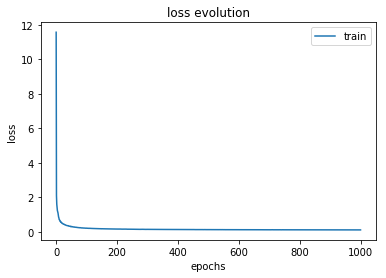

In [113]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
out_batch = NEpochLogger(display=50)
model.main_train(dataset, training_epochs=1000, batch_size=20, verbose=False,callbacks=[tensorboard,out_batch])

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

In [130]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    file.write(str(emb_dims) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

In [131]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [132]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [133]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [134]:
temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond_pre = dataset['train']['x'][1]
cond_emb = model.embedding.predict(dataset['train']['x'][2])
cond = np.concatenate((cond_pre, cond_emb), axis=1)

#cond  = dataset['train']['x'][1]
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

In [135]:
cond_emb.shape

(1830, 4)

In [136]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])

In [137]:
log_dir=path_main_folder+"/notebooks/logs/projector_Conso_WeekDay_Temp_4couches"
os.makedirs(log_dir)

FileExistsError: [Errno 17] File exists: '/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_WeekDay_Temp_4couches'

In [138]:
import os,cv2
images=createLoadProfileImages(x,x_hat,nPoints)

<Figure size 432x288 with 0 Axes>

In [139]:

sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [140]:

x_reduced=x_encoded[0:nPoints,]
writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images,log_dir)

## Analyse prédiction de température
On essaie de prédire la température avec les plus proches voisins. Normalement on drevrait etre meilleur que dans l'autoencoder originel et ensuite on devrait etre moins bons une fois la tempréature prise en compte

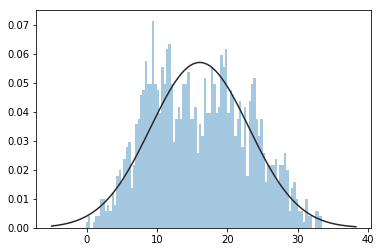

In [141]:
temperatureMax=[max(x_conso.loc[index*48:(index+1)*48-1,'meteo_natTh+0']) for index in range(0,nPoints)]
import seaborn as sn
sn.distplot(temperatureMax, kde=False, fit=stats.norm, bins=100)

In [142]:
from sklearn.neighbors import KNeighborsRegressor
k=5
knn = KNeighborsRegressor(n_neighbors=k)

yTemp=temperatureMax

knn.fit(x_reduced, yTemp)
train_accuracy= knn.score(x_reduced, yTemp)
train_accuracy

0.4276915357509482

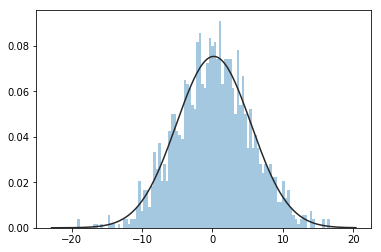

In [143]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)
#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

## classification si espace random


In [144]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsRegressor(n_neighbors=k)
knn_random.fit(x_reduced_random, yTemp)
train_accuracy_random= knn_random.score(x_reduced_random, yTemp)
train_accuracy_random

0.18299471730335226

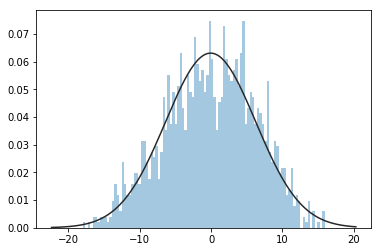

In [145]:
from sklearn.metrics import confusion_matrix
y_pred = knn_random.predict(x_reduced_random)
error=y_pred-yTemp
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  